# Theoretical spectra integration 
## Comparison of simulated and experimental spectra

In [1]:
from ramanchada2.theoretical_lines.model_from_lines import model_from_lines
from ramanchada2.io.simulated.read_simulated_lines import read_simulated_lines
from ramanchada2.io.simulated.crystal.discrete_lines_dat import lines_from_crystal_dat
from ramanchada2 import spectrum

from lmfit import Model, Parameters
from lmfit.models import VoigtModel, GaussianModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
vasp_sim_fn = '../../tests/data/simulations/vasp/snCAL_vasp_raman_ALL.dat'
crystal_sim_raw_fn = '../../tests/data/simulations/crystal/calcite_CRYSTAL_PBE_raw_data.dat'
crystal_sim_convolved_fn = '../../tests/data/simulations/crystal/calcite_CRYSTAL_PBE_convoluted.dat'

exp_spe_fn = '../../tests/data/experimental/Renishaw/nCal_Qontor785_z005H12_100_1x3s.spc'

## read _vasp_ simulation for CAL

In [3]:
def get_model_pars(filename, sim_type, *spe_type):
    return model_from_lines(
        *read_simulated_lines(
            open(filename),
            sim_type=sim_type,
            use=spe_type
        ),
        #model='gaussian'
    )


def get_spectrum(filename, sim_type, *spe_type):
    mod, pars = get_model_pars(filename, sim_type, *spe_type)
    return spectrum.from_theoretical_lines(mod, pars, x=2000)



ValidationError: 2 validation errors for from_theoretical_lines
0
  Input should be a valid list [type=list_type, input_value=(((((((((((((((((((((((((..., prefix='I_perp__30_')), input_type=CompositeModel]
    For further information visit https://errors.pydantic.dev/2.9/v/list_type
1
  Input should be a valid list [type=list_type, input_value=Parameters([('pedestal', ...f:inf], expr='sigma'>)]), input_type=Parameters]
    For further information visit https://errors.pydantic.dev/2.9/v/list_type

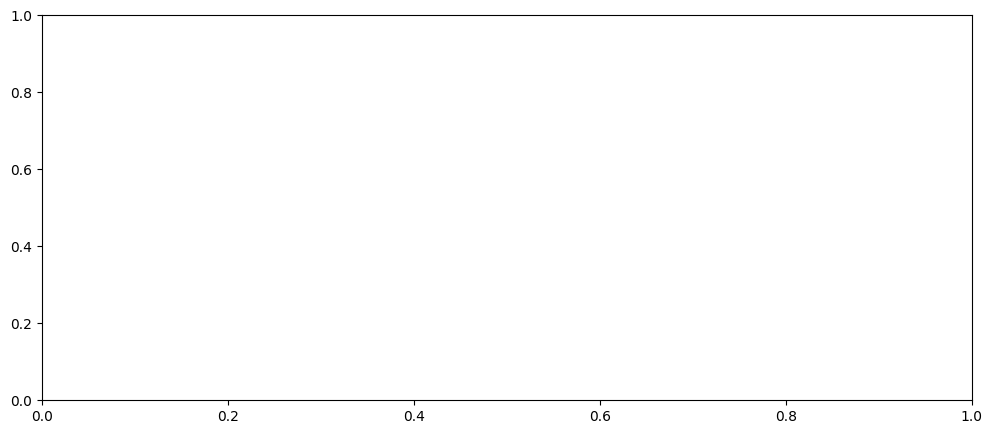

In [4]:
#vasp_par['sigma'].set(value=3)
#vasp_spe = spectrum.from_theoretical_lines(vasp_mod, vasp_par, x=2000)
#vasp_spe.plot()
fig, ax = plt.subplots(1, figsize=(12, 5))
get_spectrum(vasp_sim_fn, 'vasp', 'I_perp', 'I_par').plot(ax=ax, label='I_perp+I_par')
get_spectrum(vasp_sim_fn, 'vasp', 'I_par').plot(ax=ax, label='I_par')
get_spectrum(vasp_sim_fn, 'vasp', 'I_perp').plot(ax=ax, label='I_perp')
get_spectrum(vasp_sim_fn, 'vasp', 'I_tot').plot(ax=ax, label='I_tot')

In [ ]:
read_simulated_lines(open(crystal_sim_raw_fn), 'crystal_dat')

## Compare a typical experimental spectrum with _vasp_ and _crystal_ simulations

In [ ]:
with open(crystal_sim_convolved_fn) as f:
    crystal_convolved = lines_from_crystal_dat(f)
    
fig, ax = plt.subplots(4, figsize=(7, 4), sharex=True)
ax[0].set_ylabel('Exp\n[a.u.]')
ax[1].set_ylabel('I_tot\n[a.u.]')
ax[2].set_ylabel('I_par\n[a.u.]')
ax[3].set_ylabel('I_perp\n[a.u.]')
ax[3].set_xlabel('Raman shift [$\mathrm{cm}^{-1}$]')

for i, k in enumerate([
    'I_tot',
    'I_par',
    'I_perp',
    #'I_xx',
    #'I_xy',
    #'I_xz',
    #'I_yy',
    #'I_yz',
    #'I_zz'
]):
    get_spectrum(crystal_sim_raw_fn, 'crystal_dat', k).normalize().plot(ax=ax[i+1], fmt='r', label=f"Crystal")
    ax[i+1].legend()

exp_spe = spectrum.from_local_file(exp_spe_fn)
exp_spe.normalize().plot(ax=ax[0], label="nCAL; 785 nm")

get_spectrum(vasp_sim_fn, 'vasp', 'I_tot').normalize().plot(ax=ax[1], fmt='g', label='Vasp')
get_spectrum(vasp_sim_fn, 'vasp', 'I_par').normalize().plot(ax=ax[2], fmt='g', label='Vasp')
get_spectrum(vasp_sim_fn, 'vasp', 'I_perp').normalize().plot(ax=ax[3], fmt='g', label='Vasp')

#vasp_spe.plot(ax=ax[1], label='vasp')
ax[0].set_xlim(-100, 1800)
#ax.legend()
for a in ax:
    a.legend(loc='upper right')
    a.grid(color='y', linestyle=':', linewidth=.5)
None
fig.suptitle('CAL - Experiment vs Simulation')
fig.savefig('cal.pdf')


## read _crystal_ simulation

In [ ]:
with open(crystal_sim_raw_fn) as f:
    crystal_lines = lines_from_crystal_dat(f)

## build a model and find `sigma`, `x0` and `x1` parameters based on _I_perp_ and _I_par_

In [ ]:
exp_spe_au = exp_spe.normalize()
mod, pars = get_model_pars(crystal_sim_raw_fn, 'crystal_dat', 'I_par', 'I_perp')
result_crystal = mod.fit(exp_spe_au.y, params=pars, x=exp_spe_au.x)

mod, pars = get_model_pars(vasp_sim_fn, 'vasp', 'I_par', 'I_perp')
result_vasp = mod.fit(exp_spe_au.y, params=pars, x=exp_spe_au.x)

In [ ]:
fig, ax = plt.subplots(1, figsize=(7, 4))
exp_spe.plot(ax=ax, label="Experimental")
x = np.arange(-100, 2000)
pars['I_perp_amplitude'].set(value=10)
pars['I_par_amplitude'].set(value=10)
r = mod.eval(params=pars, x=x)
ax1 = ax.twinx()
ax1.plot(x, r, 'r')
ax.set_xlim(xmax=2000)

result = mod.fit(exp_spe.y, params=pars, x=exp_spe.x)


In [ ]:
def ratio_string(result):
    ss = result.params['I_par_amplitude']+result.params['I_perp_amplitude']
    return f"I_par {result.params['I_par_amplitude'] / ss*100:.0f} %\nI_perp {result.params['I_perp_amplitude']/ss*100:.0f} %"
ratio_string(result_crystal), ratio_string(result_vasp)

In [ ]:
x = np.arange(-100, 2000)
y_crystal = result_crystal.eval(x=x)
y_vasp = result_vasp.eval(x=x)

fig, ax = plt.subplots(1, figsize=(5, 3), tight_layout=True)
ax.plot(exp_spe_au.x, exp_spe_au.y, label="Experimental", lw=1)
ax.plot(x, y_vasp, '-.', label=ratio_string(result_vasp), lw=1)
ax.set_xlim(xmax=2000)
ax.legend(loc='upper left')
ax.set_xlabel('Raman shift [$\mathrm{cm}^{-1}$]')
ax.set_ylabel('Intensity [a.u.]')
ax.set_title('nCAL, Best fit Vasp')

fig.savefig('cal-fit-vasp.pdf')


fig, ax = plt.subplots(1, figsize=(5, 3), tight_layout=True)
ax.plot(exp_spe_au.x, exp_spe_au.y, label="Experimental", lw=1)
ax.plot(x, y_crystal, '--', label=ratio_string(result_crystal), lw=1)
ax.set_xlim(xmax=2000)
ax.legend(loc='upper left')

ax.set_title('nCAL, Best fit Crystal')

ax.set_xlabel('Raman shift [$\mathrm{cm}^{-1}$]')
ax.set_ylabel('Intensity [a.u.]')

fig.savefig('cal-fit-crystal.pdf')



In [ ]:
spe_types = [
    #'I_tot',
    'I_par',
    'I_perp',
    #'I_xx',
    #'I_xy',
    #'I_xz',
    #'I_yy',
    #'I_yz',
    #'I_zz'
]

lm_model = VoigtModel
crystal_par_perp_model = np.sum([
    lm_model(prefix=f"{spe_t}_{li}_", name=f"{spe_t}_{li}")
    for spe_t in spe_types
    for li in range(len(crystal_lines['Frequencies']))
])

crystal_par_perp_params = Parameters()
crystal_par_perp_params.add('sigma', 2, min=0)
crystal_par_perp_params.add('x0', 0)
crystal_par_perp_params.add('x1', 1)
for spe_t in spe_types:
    crystal_par_perp_params.add(f'{spe_t}_amplitude', 200, min=0)
    crystal_par_perp_params.add(f'{spe_t}_pedestal', 0, min=0)
    for i, pos, intens in zip(range(len(crystal_lines['Frequencies'])),
                              crystal_lines['Frequencies'].values,
                              crystal_lines[spe_t].values
                             ):
        prefix = f"{spe_t}_{i}_"
        crystal_par_perp_params.add(prefix+'amplitude', expr=f"({intens}*{spe_t}_amplitude)+{spe_t}_pedestal")
        crystal_par_perp_params.add(prefix+'center', expr=f"({pos}*x1)+x0")
        crystal_par_perp_params.add(prefix+'sigma', expr='sigma')
    

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,5))
ax.plot(exp_spe.x, exp_spe.y, label='spe nCAL')

ax.plot(crystal_par_perp_model.eval(params=crystal_par_perp_params, x=np.arange(0, 2000)), label='CRYSTAL sim')

ax.set_xlim(xmax=2000)

ax.legend()
show_keys = ['x0', 'x1', 'I_perp_amplitude', 'I_par_amplitude', 'sigma']
{k: v for k, v in crystal_par_perp_params.items() if k in show_keys}

In [ ]:
result = crystal_par_perp_model.fit(exp_spe.y, crystal_par_perp_params, x=exp_spe.x)
#result.values

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,5))
ax.plot(exp_spe.x, exp_spe.y, label='exp spe nCAL')

ax.plot(result.eval(x=np.arange(4000)), '--', label='par perp best fit')

ax.plot(crystal_par_perp_model.eval(params=crystal_par_perp_params, x=np.arange(0, 2000)), ':', label='Initial guess')

ax.set_xlim(xmax=2000)
ax.legend()
show_keys = ['x0', 'x1', 'I_perp_amplitude', 'I_par_amplitude', 'sigma']

[
    {k: v.value for k, v in result.init_params.items() if k in show_keys},
    {k: v.value for k, v in result.params.items() if k in show_keys}
]

## fix `sigma`, `x0` and `x1` and find percentages of I_xx, I_xy, ...

In [ ]:
spe_types = [
    #'I_tot',
    #'I_par',
    #'I_perp',
    'I_xx',
    'I_xy',
    'I_xz',
    'I_yy',
    'I_yz',
    'I_zz'
]

lm_model = VoigtModel
crystal_all_model = np.sum([
    lm_model(prefix=f"{spe_t}_{li}_", name=f"{spe_t}_{li}")
    for spe_t in spe_types
    for li in range(len(crystal_lines['Frequencies']))
])
crystal_all_params = Parameters()
crystal_all_params.add('sigma', result.values['sigma'], min=0, vary=False)
crystal_all_params.add('x0', result.values['x0'], vary=False)
crystal_all_params.add('x1', result.values['x1'], vary=False)
for spe_t in spe_types:
    crystal_all_params.add(f'{spe_t}_amplitude', 200, min=0)
    crystal_all_params.add(f'{spe_t}_pedestal', 0, min=0, vary=False)
    for i, pos, intens in zip(range(len(crystal_lines['Frequencies'])),
                          crystal_lines['Frequencies'].values,
                          crystal_lines[spe_t].values
                         ):
        prefix = f"{spe_t}_{i}_"
        crystal_all_params.add(prefix+'amplitude', expr=f"({intens}*{spe_t}_amplitude)+{spe_t}_pedestal")
        crystal_all_params.add(prefix+'center', expr=f"({pos}*x1)+x0")
        crystal_all_params.add(prefix+'sigma', expr='sigma')
    

In [ ]:
result = crystal_all_model.fit(exp_spe.y, crystal_all_params, x=exp_spe.x)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,5))
ax.plot(exp_spe.x, exp_spe.y, label='spe nCAL')

ax.plot(result.eval(x=np.arange(4000)), '--', label='CRYSTAL sim')
ax.set_xlim(xmax=2000)
ax.legend()
show_keys = ['I_xx_amplitude', 'I_xy_amplitude', 'I_xz_amplitude', 'I_yy_amplitude', 'I_yz_amplitude', 'I_zz_amplitude']
ratio = np.array([v.value for k, v in result.params.items() if k in show_keys])
ratio /= ratio.sum()
ratio *= 100
for k, v in zip(show_keys, ratio):
    print(f'{k}    {v:5.1f} %')

- vasp simulation with nearly identical output to crystal $I_{total}$
- explain discrepancies between simulated and experimental spectra
- not corresponding peaks